# Probe-Probe Output Distance
**Goal**: Analyze the distance between the output representation of each set of probes

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_distances, manhattan_distances
sns.set_style('darkgrid')

# Load Probes Data

In [2]:
all_probes_data = []

for dilution in range(1, 4):
    # Load probes data
    probes_data = pd.read_pickle(f'pmsp-recurrent-dt-100-dilution-{dilution}-seed-1/activations-probes-output.pkl')
    probes_data['dilution'] = dilution
    all_probes_data.append(probes_data)

all_probes_data = pd.concat(all_probes_data)

# Load anchor-probes mapping
anchor_probe_mapping = pd.read_pickle(f'../../dataset/anchor_probe_mapping_dilution_3.pkl')

In [3]:
all_probes_data.head()

,epoch,output,word_id,orth,phon,word_type,target,dilution
0,1850,"[0.0001450888, 0.00109781, 0.0006799259, 0.005...",0,vlit,vlit,PRO_REG,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",1
1,1850,"[0.0003808585, 1.624781e-05, 3.683219e-06, 0.0...",1,plit,plit,PRO_REG,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
2,1850,"[0.0002138509, 0.0008424883, 2.237946e-07, 0.0...",2,trit,trit,PRO_REG,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
3,1850,"[0.0001903396, 0.00261161, 2.054666e-06, 0.008...",3,drit,drit,PRO_REG,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
4,1850,"[2.357826e-06, 0.001128587, 0.0001108942, 0.02...",4,frax,frks,PRO_REG,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",1


In [4]:
anchor_probe_mapping.head()

,anchor,probes,type
0,"[slit, dit, yit]","[vlit, plit, trit, drit]",REG
1,"[thax, chax, brax]","[frax, drax, prax, shrax]",REG
2,"[kleef, pleef, smeef]","[bleef, gleef, creef, preef]",REG
3,"[krim, plim, drim]","[blim, clim, shrim, frim]",REG
4,"[nisp, fisp, chisp]","[bisp, kisp, risp, tisp]",REG


## Calculation of Distance between Probes

We use two distance metrics - cosine distance, and L1 distance. The documentation for these two distance metrics are available here:
* [Cosine Distance](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_distances.html#sklearn.metrics.pairwise.cosine_distances)
* [Manhattan Distance](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.manhattan_distances.html#sklearn.metrics.pairwise.manhattan_distances)

In [5]:
results = []
for dilution in [1, 2, 3]:
    probes_data = all_probes_data[all_probes_data['dilution'] == dilution]

    for i, row in tqdm(anchor_probe_mapping.iterrows(), total=len(anchor_probe_mapping), desc=f"Dilution {dilution}"):
        probes_output = probes_data[probes_data['orth'].isin(row['probes'])]

        for epoch in probes_data['epoch'].unique():
            epoch_probe_output = np.array(probes_output[probes_output['epoch'] == epoch]['output'].tolist())

            results.append({
                'dilution': dilution,
                'epoch': epoch,
                'probes': row['probes'],
                'type': row['type'],
                'cosine_distances': cosine_distances(epoch_probe_output, epoch_probe_output),
                'l1_distances': manhattan_distances(epoch_probe_output, epoch_probe_output)
            })

Dilution 3: 100%|██████████| 27/27 [00:02<00:00,  9.55it/s]


In [6]:
results_df = pd.DataFrame(results)
results_df['mean_cosine_distance'] = results_df['cosine_distances'].apply(lambda x: x.mean())
results_df['mean_l1_distance'] = results_df['l1_distances'].apply(lambda x: x.mean())
results_df['first_probe'] = results_df['probes'].apply(lambda x: x[0])
results_df = results_df.sort_values(by=['epoch', 'type', 'first_probe']).reset_index(drop=True)

In [7]:
results_df.head()

,dilution,epoch,probes,type,cosine_distances,l1_distances,mean_cosine_distance,mean_l1_distance,first_probe
0,1,1850,"[blone, frone, slone, smone]",AMB,"[[0.0, 0.7117399976605336, 0.2498332289326326,...","[[0.0, 5.602381138743598, 2.2393903718272, 6.4...",0.448606,3.719332,blone
1,2,1850,"[blone, frone, slone, smone]",AMB,"[[0.0, 0.7117399976605336, 0.2498332289326326,...","[[0.0, 5.602381138743598, 2.2393903718272, 6.4...",0.448606,3.719332,blone
2,3,1850,"[blone, frone, slone, smone]",AMB,"[[0.0, 0.7117399976605336, 0.2498332289326326,...","[[0.0, 5.602381138743598, 2.2393903718272, 6.4...",0.448606,3.719332,blone
3,1,1850,"[brour, drour, prour, clour]",AMB,"[[0.0, 0.269458988109221, 0.4660629440471833, ...","[[0.0, 2.2171524830736002, 3.8447141881659, 5....",0.415136,3.205658,brour
4,2,1850,"[brour, drour, prour, clour]",AMB,"[[0.0, 0.269458988109221, 0.4660629440471833, ...","[[0.0, 2.2171524830736002, 3.8447141881659, 5....",0.415136,3.205658,brour


## Mean Cosine and L1 Distance by Probe Type

This first pair of graphs aggregate all three dilution levels together.

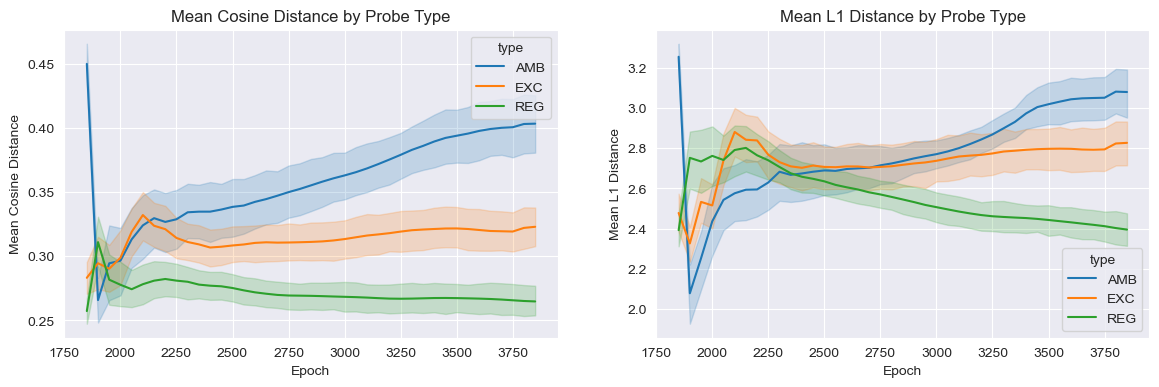

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

sns.lineplot(data=results_df, x='epoch', y='mean_cosine_distance', hue='type', ax=ax1, ci=68)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Mean Cosine Distance')
ax1.set_title('Mean Cosine Distance by Probe Type')

sns.lineplot(data=results_df, x='epoch', y='mean_l1_distance', hue='type', ax=ax2, ci=68)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean L1 Distance')
ax2.set_title('Mean L1 Distance by Probe Type')

plt.show()

In the next 3 sets of graphs, we look at each regularity type individually, but combine all three dilution levels in the same plot.

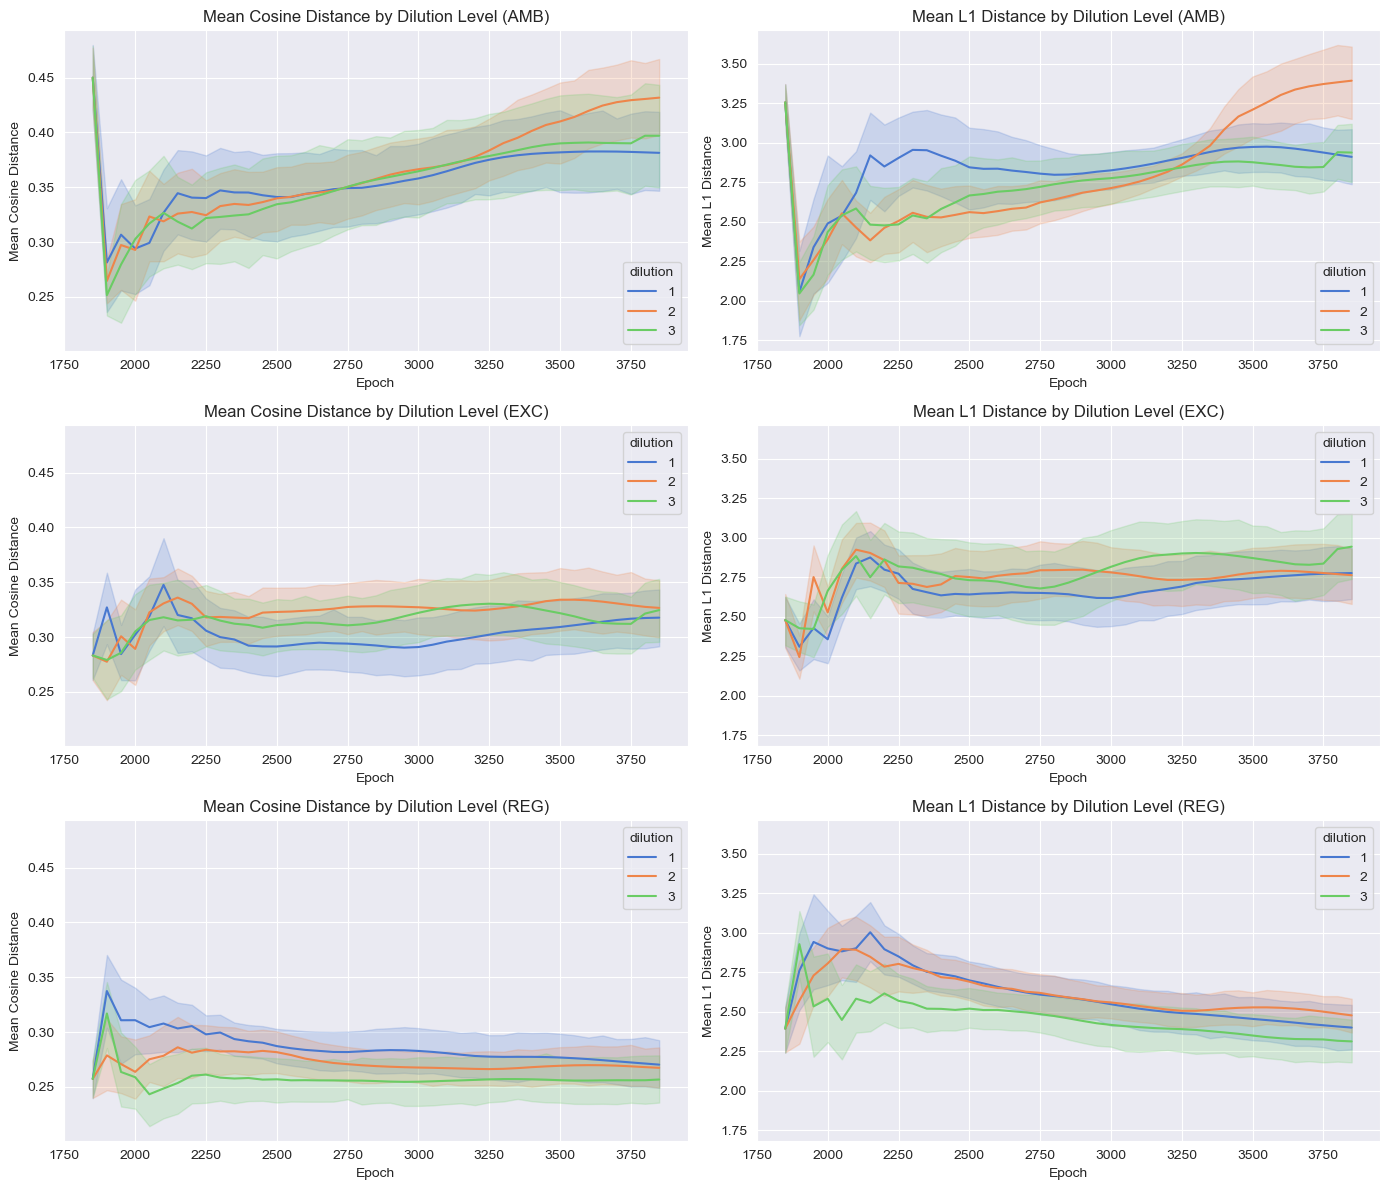

In [9]:
fig, axs = plt.subplots(3, 2, figsize=(14, 12), sharey='col')

for word_type, ax in zip(results_df['type'].unique(), axs):
    sns.lineplot(data=results_df[results_df['type'] == word_type], x='epoch', y='mean_cosine_distance', hue='dilution',
                 ax=ax[0], ci=68, palette='muted')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Mean Cosine Distance')
    ax[0].set_title(f'Mean Cosine Distance by Dilution Level ({word_type})')

    sns.lineplot(data=results_df[results_df['type'] == word_type], x='epoch', y='mean_l1_distance', hue='dilution',
                 ax=ax[1], ci=68, palette='muted')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean L1 Distance')
    ax[1].set_title(f'Mean L1 Distance by Dilution Level ({word_type})')

plt.tight_layout()
plt.show()

In the next 3 sets of graphs, we look at each dilution level individually, but combine all three regularity types in the same plot.

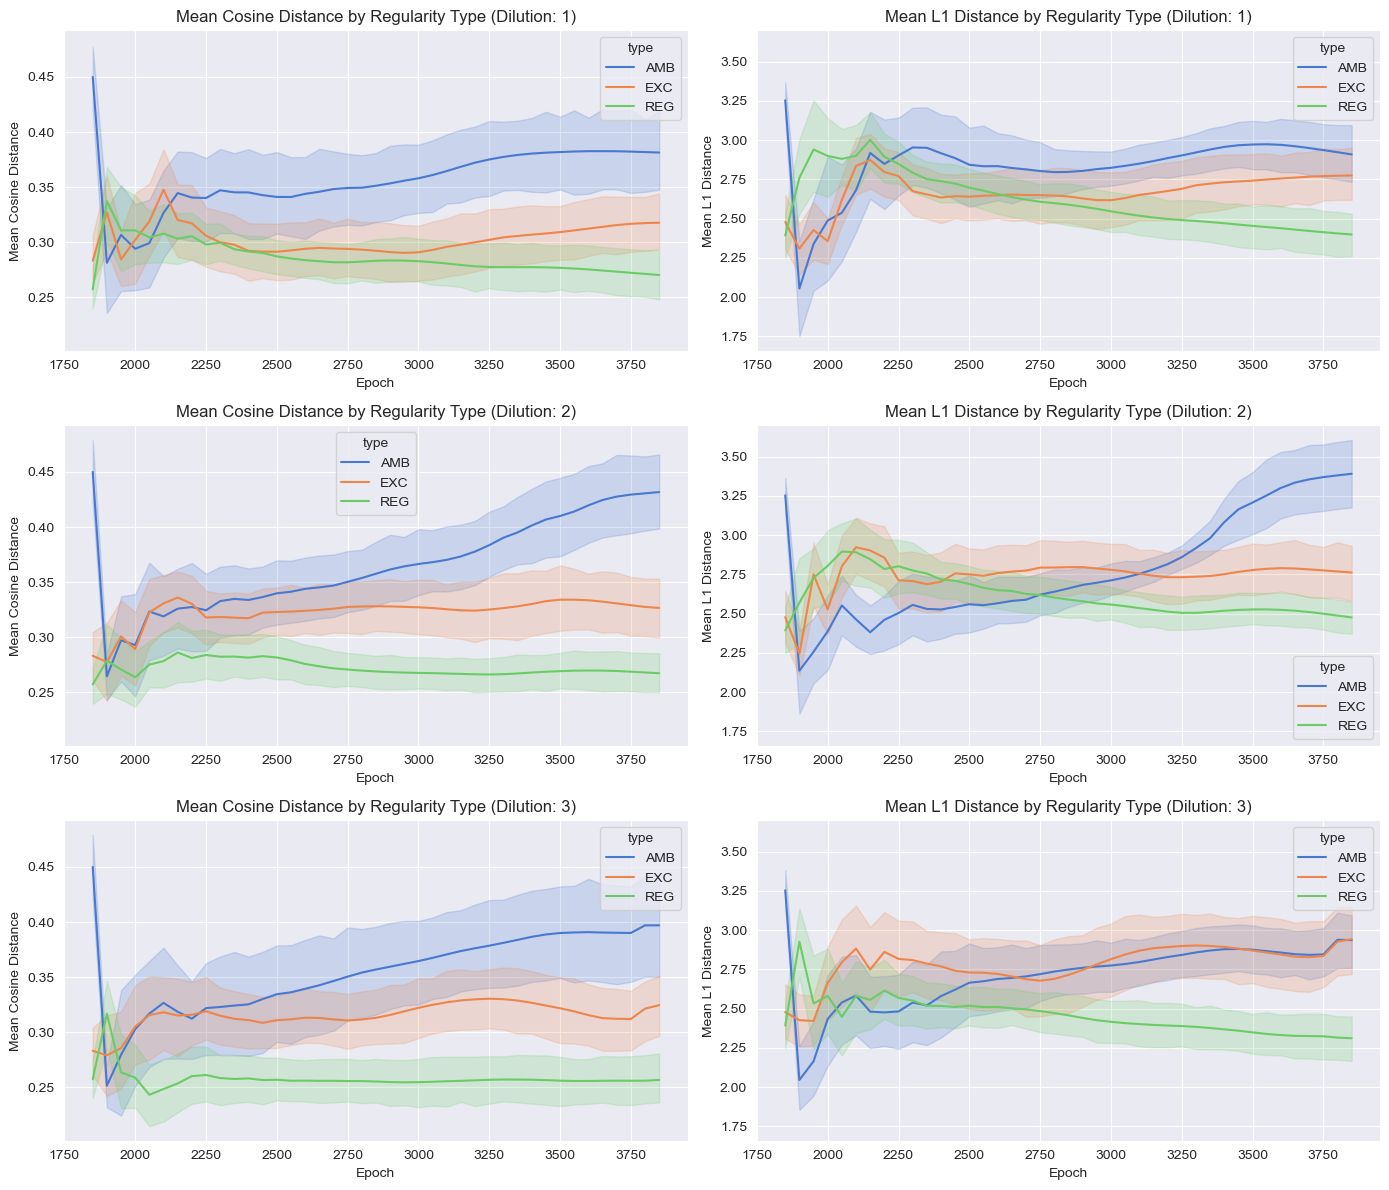

In [10]:
fig, axs = plt.subplots(3, 2, figsize=(14, 12), sharey='col')

for dilution, ax in zip(results_df['dilution'].unique(), axs):
    sns.lineplot(data=results_df[results_df['dilution'] == dilution], x='epoch', y='mean_cosine_distance', hue='type',
                 ax=ax[0], ci=68, palette='muted')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Mean Cosine Distance')
    ax[0].set_title(f'Mean Cosine Distance by Regularity Type (Dilution: {dilution})')

    sns.lineplot(data=results_df[results_df['dilution'] == dilution], x='epoch', y='mean_l1_distance', hue='type',
                 ax=ax[1], ci=68, palette='muted')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean L1 Distance')
    ax[1].set_title(f'Mean L1 Distance by Regularity Type (Dilution: {dilution})')

plt.tight_layout()
plt.show()

## Probe-Probe Distance by Set
* We refer to each probe set by the first probe.

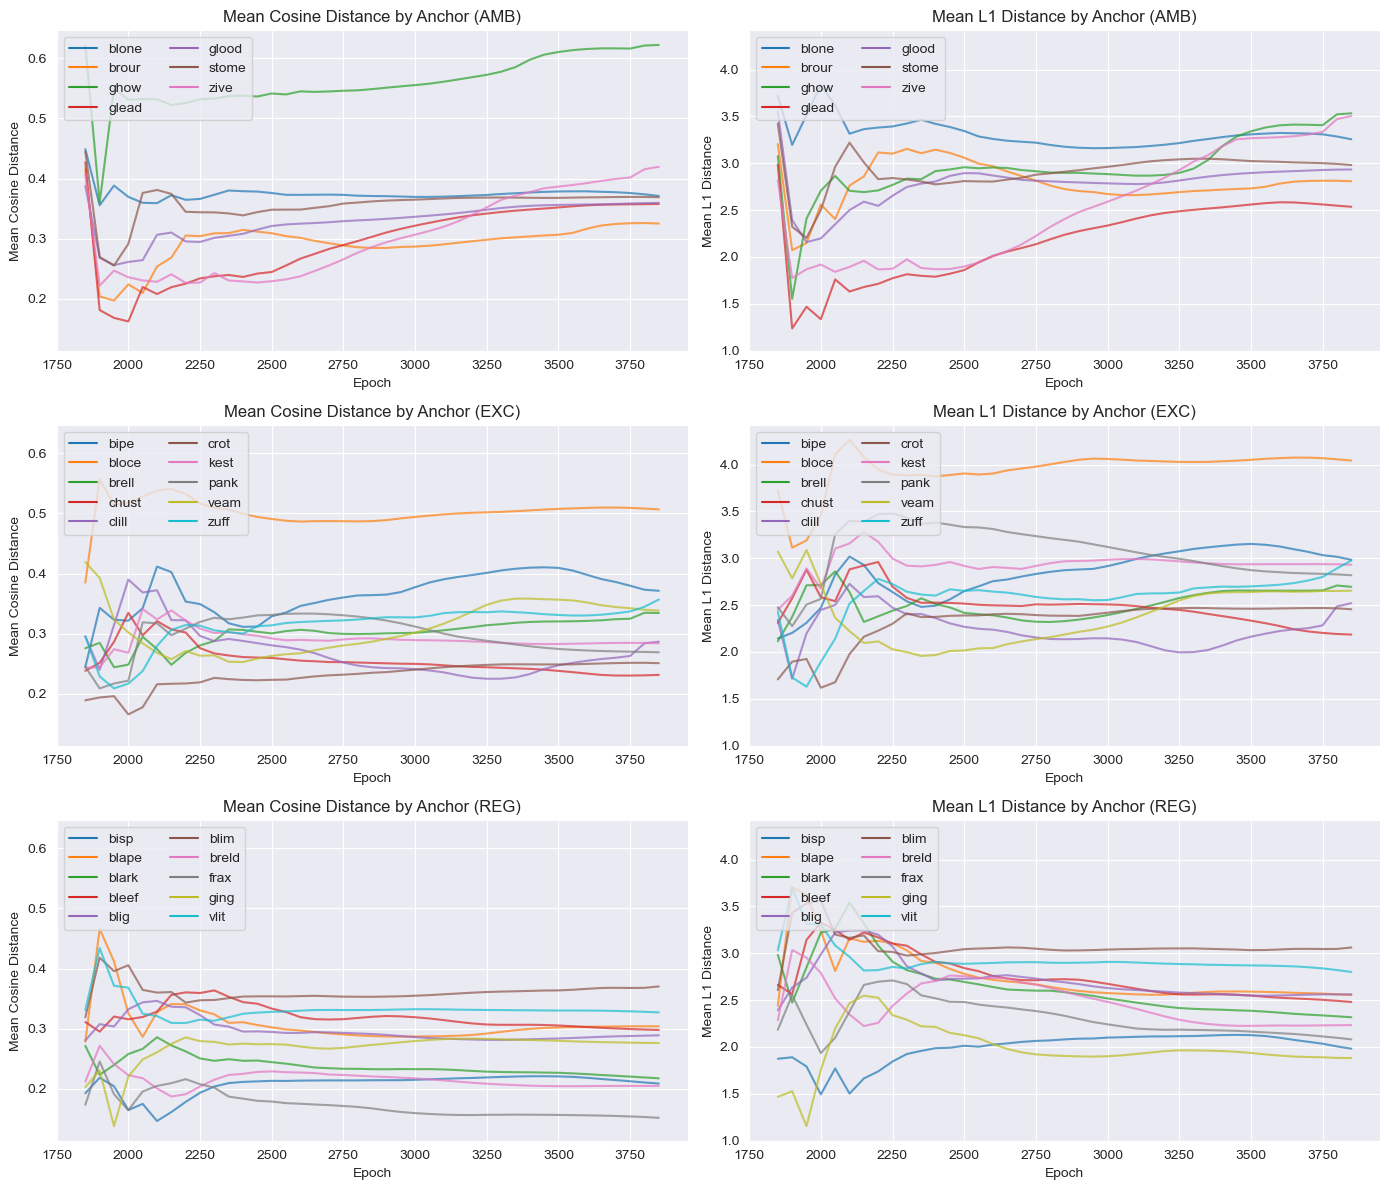

In [11]:
fig, axs = plt.subplots(3, 2, figsize=(14, 12), sharey='col')

for word_type, ax in zip(results_df['type'].unique(), axs):
    sns.lineplot(data=results_df[results_df['type'] == word_type], x='epoch', y='mean_cosine_distance', hue='first_probe',
                 alpha=0.7, ax=ax[0], ci=None)
    ax[0].legend(ncol=2, loc='upper left')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Mean Cosine Distance')
    ax[0].set_title(f'Mean Cosine Distance by Anchor ({word_type})')

    sns.lineplot(data=results_df[results_df['type'] == word_type], x='epoch', y='mean_l1_distance', hue='first_probe',
                 alpha=0.7, ax=ax[1], ci=None)
    ax[1].legend(ncol=2, loc='upper left')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean L1 Distance')
    ax[1].set_title(f'Mean L1 Distance by Anchor ({word_type})')

plt.tight_layout()
plt.show()